## SFI5904 - Redes Complexas

Projeto Prático 4: Modelo de redes Barbási-Albert<br>
Primeiro Semestre de 2021

Docente: Luciano da Fontoura Costa (luciano@ifsc.usp.br) <br>

Estudante: Bruno F. Bessa (num. 5881890, bruno.fernandes.oliveira@usp.br) <br>
Universidade de São Paulo, São Carlos, Brasil.

<b>Escopo do projeto:</b>

Implementar redes de Barbási-Albert considerando diferentes valores de probabilidade de <br>
reconexão. <br>

Visualizar algumas das redes geradas. Apresentar: 
 - os histogramas de frequência relativa dos graus, 
 - coeficientes de aglomeração e distâncias mínimas, identificando nas respectivas legendas a média e o desvio padrão.

In [1]:
# Importação de bibliotecas necessárias para o processamento e visualização

import random
import numpy as np
import scipy
import math
import secrets
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm
import time
from IPython import display

In [30]:
# Definição das redes e rotinas para cálculo de métricas

def random_graph(N_random:int = 10) -> nx.classes.graph.Graph:
    """
    Define um grafo de N nodos e conexões aleatórias entre eles.
    """
    
    G = nx.Graph()
    for node in range(N_random+1):
        G.add_node(node)
        
    nodes = list(G.nodes())    
    for node in nodes:
        random_node = secrets.choice(nodes)
        G.add_edge(node, random_node)           
    
    return G

def ba_graph(N: int, 
             m: int = 3,
             plot: bool = True,
             file_name: str = None) -> nx.classes.graph.Graph:
    """
    Define a rede de Barbási-Albert acrescentando a uma rede aleatória novos nodos.
    Os nodos acrescentados são inseridos conforme a lógica de "associação preferencial", 
    com chance maior de serem ligados a nós com grau elevado.
    """
    
    G = random_graph()
    dict_degree = dict(G.degree())
    list_k_nodes = []
    for k_value, k_freq in dict_degree.items():
        for freq in range(k_freq):
            list_k_nodes.append(k_value)
            
    for node in range(len(G), N-1):
        for conn in range(m):
            random_node = secrets.choice(list_k_nodes)
            G.add_edge(node, random_node)
            
    # Para calcularmos medidas de distância precisaremos remover nós não conectados
    # No trecho abaixo mantemos somente o maior componente conctado da rede.
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    if plot:
        pos = nx.spring_layout(G)
        fig_net = nx.draw(G, pos, node_color='w', node_size=1, with_labels=False)
        plt.suptitle("Rede Barási-Albert com {} nodos, m={}".format(N, m), fontsize=15)
        plt.show(fig_net)
    
    if file_name != None:
        pos = nx.spring_layout(G)
        fig_net = nx.draw(G, pos, node_color='w', node_size=1, with_labels=False)
        plt.suptitle("Rede Barási-Albert com {} nodos, m={}".format(N, m), fontsize=15)
        plt.savefig("images/"+file_name)          
        plt.close(fig_net)            

    return G

def avg_shortest_path(G: nx.classes.graph.Graph) -> float:
    """
    Percorre todos os nodos do grafo e para cada um deles verifica o menor caminho até todos os demais.
    Retorna a média desses valoeres.
    Disclaimer: this function uses shortest_path_length build in function from NetworkX library.
    """
    dict_shortest_paths = nx.shortest_path_length(G)
    node_path_avg = []
    for node, paths in dict_shortest_paths:
        node_path_avg.append(sum(paths.values())/len(G.nodes()))
    
    return sum(node_path_avg)/len(node_path_avg)

def test_avg_shortest_path(N: int, p: list, sample: int = 1) -> float:

    #pbar = tqdm(total=n*sample)
    avg_sp = []
    for s in range(sample):
        G = regular_reticulated(N, False)
        reconnect_regular(G, p, False)
        avg_sp.append(avg_shortest_path(G))
        #pbar.update(n)
    
    #pbar.close()
    return sum(avg_sp)/len(avg_sp)

def plot_avg_shortest_path(N: int, sample: int, file_name:str = None) -> None:
    
    p = [0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1]
    SP = [test_avg_shortest_path(n, x, sample) for x in p]  
    
    fig, ax = plt.subplots()
    ax.plot(p, SP,'k--', label='Num. de nodos {}'.format(n))
    legend = ax.legend(loc='upper right')
    plt.xlabel('Probabilidade de reconexão')
    plt.ylabel("Menor tamanho médio")
    plt.show()

    if filename != None:
        fig.savefig("images/"+file_name)

def degree_distribution(G: nx.classes.graph.Graph) -> list:

    """
    Retorna a lista de valores de grau (k) para todos os nós da rede.
    """

    dict_degree = dict(G.degree())
    list_k = []
    for node, k_value in dict_degree.items():
        list_k.append(k_value)    
    
    return list_k
    
def clustering_coef_distribution(G: nx.classes.graph.Graph) ->list:
    
    """
    Retorna a lista de valores de cluster coefficient (cc) para todos os nós da rede.

    """
    
    list_cc_nodes = []
    for node in G.nodes():
        list_cc_nodes.append(nx.clustering(G, node))

    return list_cc_nodes
        
def spl_distribution(G: nx.classes.graph.Graph) ->list:
    """
    Retorna a lista de valores de shortest path length (spl) para todos os nós da rede.

    """    
    
    N = len(G)
    if nx.is_connected(G) == True:
        distance_matrix = np.zeros(shape=(N,N)) 
        diameter = nx.diameter(G)
        slp_values = []        
        for i in np.arange(0,N):
            for j in np.arange(i+1, N):
                if(i != j):
                    aux = nx.shortest_path(G,i,j)
                    dij = len(aux)-1
                    distance_matrix[i][j] = dij
                    distance_matrix[j][i] = dij
                    slp_values.append(dij)        
        return slp_values
    else:
        pass
    
def shannon_entropy(G: nx.classes.graph.Graph) ->float:
    
    """
    Calcula a entropia de Shannon para um grafo G recebido como parâmetro.
    """
    list_k = degree_distribution(G)
    min_k = np.min(list_k)
    max_k = np.max(list_k)

    k_values= np.arange(0,max_k+1) 
    k_prob = np.zeros(max_k+1) 
    for k in list_k:
        k_prob[k] = k_prob[k] + 1
    k_prob = k_prob/sum(k_prob)
    
    H = 0
    for p in k_prob:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H
        
def distribution_plot(list_values: list,
                     plot_title: str = "Histograma de densidade",
                     var_name: str = "Variável",
                     file_name: str = None) -> None:
    """
    Produz histgrama de uma medida recebida na forma de lista.
    """
    
    avg_value = np.mean(list_values) 
    var_value = np.var(list_values)
    
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(list_values, density=True)
    ax.set_xlabel(var_name)
    ax.set_ylabel("Densidade de probabilidade")
    ax.set_title("{} de {}: média={:.2f}, var={:.2f}".format(plot_title, 
                                                             var_name, 
                                                             avg_value, 
                                                             var_value), 
                                                             fontsize=15)
    plt.show(True)
    if file_name != None:
        fig.savefig("images/"+file_name)
        
def correlation_plot(x: list, 
                         y: list, 
                         x_label: str = "x", 
                         y_label: str = "y", 
                         file_name: str = None) -> None:
    """
    Produz gráfico de dispersão de duas variáveis x e y recebidas na forma de listas.
    Calcula correlação de Pearson e Spearman para x e y.
    """    
    
    pearson_corr = np.corrcoef(x, y)[0,1]
    spearman_corr, spearman_pval = scipy.stats.spearmanr(x, y)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title("Dispersão de {} e {}: Pearson: {:.2f}, Spearman: {:.2f} (p-val: {:.3f})".format(x_label, 
                                                                                           y_label,
                                                                                           pearson_corr,
                                                                                           spearman_corr,
                                                                                           spearman_pval), 
                                                                                           fontsize=15)
    plt.show(True)
    if file_name != None:
        fig.savefig("images/"+file_name)
        
def simple_plot2d(x: list, 
                     y: list, 
                     x_label: str = "x", 
                     y_label: str = "y", 
                     file_name: str = None) -> None:
    """
    Produz gráfico simples com associação entre suas variáveis x e y recebidas na forma de listas.
    """    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title("Dispersão de {} e {}".format(x_label, y_label, fontsize=15))
    plt.show(True)
    if file_name != None:
        fig.savefig("images/"+file_name)
        

Vamos agora reproduzir alguns experimentos com as redes de Barbási-Albert. <br>
Para conseguirmos visualizar as conexões da rede, usaremos diferentes valores de número de nós (10 50 100, 500). <br>

In [ ]:
# Barbási-Albert
list_N = [50, 100, 200, 500]
list_m = [1, 2, 3, 4]
network_model = "barbasi_albert"

for _n in list_N:
    for _m in list_m:
        G = ba_graph(_n, _m, True, "graph_{}_n{}_m{}.jpg".format(network_model, str(_n), str(_m)))
        degree_dist = degree_distribution(G)
        cluster_dist = clustering_coef_distribution(G)
        spl_dist = spl_distribution(G)
        distribution_plot(degree_dist, var_name="Grau", file_name="degree_dist_{}_n{}_m{}.jpg".format(network_model, str(_n), str(_m)))
        distribution_plot(cluster_dist, var_name="Cluster Coefficient",file_name="cc_dist_{}_n{}_m{}.jpg".format(network_model, str(_n), str(_m)))
        distribution_plot(spl_dist, var_name="SPL", file_name="spl_dist_{}_n{}_m{}.jpg".format(network_model, str(_n), str(_m)))

        
list_N = [500]
list_m = [1, 2, 3, 4]
list_mean_k = []
list_mean_cc = []
list_mean_spl = []
list_shannon_entropy = []

for _n in list_N:
    for _m in list_m:
        G = ba_graph(_n, _m, False)
        degree_dist = degree_distribution(G)
        cluster_dist = clustering_coef_distribution(G)
        spl_dist = spl_distribution(G)
        list_mean_k.append(np.mean(degree_dist))
        list_mean_cc.append(np.mean(cluster_dist))
        list_mean_spl.append(np.mean(spl_dist))
        list_shannon_entropy.append(shannon_entropy(G))
        
simple_plot2d(list_m, list_mean_k, "m", "Grau médio", "plot2d_m_mean_k_{}.jpg".format(network_model))
simple_plot2d(list_m, list_mean_cc, "m", "Cluster Coef.", "plot2d_m_mean_cc_{}.jpg".format(network_model))
simple_plot2d(list_m, list_mean_spl, "m", "SPL médio", "plot2d_m_mean_spl_{}.jpg".format(network_model))
simple_plot2d(list_m, list_shannon_entropy, "m", "Entropia de Shannon", "plot2d_m_shannon_{}.jpg".format(network_model))


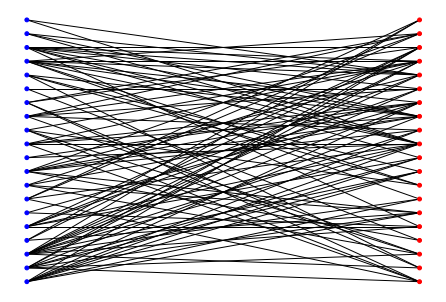

In [18]:
import networkx as nx
G = nx.bipartite.gnmk_random_graph(20,20,100, seed=123)
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
c = nx.bipartite.color(G)
color_map = []
for node in G:
    if node in list(top):
        color_map.append('blue')
    
    else: 
        color_map.append('red')      
#nx.draw(G, node_color=color_map)

nx.draw(G, pos, node_size=15, with_labels=False, node_color=color_map)

In [15]:
top

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}